# Week 6 - Classification models  

## Part 2: Travel mode choice - Logistic regression

In this part we will consider a real world problem with discrete target variables (y): travel model choice. The goal is to model the travel mode choices (plane, train, bus or car) based on trip characteristics (features) like the terminal waiting time, cost, travel time, etc. We shall start by using a logistic regression model for this.

The usual imports...

In [23]:
# Install Pyro, if necessary
!pip install pyro-ppl

Error processing line 1 of /anaconda3/lib/python3.7/site-packages/protobuf-3.10.0-py3.7-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda3/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 580, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Before we go to the modelling part, we need to prepare the data, which consists of a record of travel choices for a total of 80 individuals. 

Lets load the data using pandas:

In [25]:
# load csv
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/modechoice_data.csv")
df.head()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,0,70.0,30.0,4.0,10.0,61.0,80.0,73.0,44.0,24.0,350.0,77.0,53.0,19.0,395.0,79.0,4.0,314.0,52.0,1.0
1,1,8.0,15.0,4.0,64.0,48.0,154.0,71.0,55.0,25.0,360.0,80.0,53.0,14.0,462.0,84.0,4.0,351.0,57.0,2.0
2,2,62.0,35.0,2.0,64.0,58.0,74.0,69.0,30.0,21.0,295.0,66.0,53.0,24.0,389.0,83.0,7.0,315.0,55.0,2.0
3,3,61.0,40.0,3.0,45.0,75.0,75.0,96.0,44.0,33.0,418.0,96.0,53.0,28.0,463.0,98.0,5.0,291.0,49.0,1.0
4,4,27.0,70.0,1.0,20.0,106.0,190.0,127.0,34.0,72.0,659.0,143.0,35.0,33.0,653.0,104.0,44.0,592.0,108.0,1.0


The mode is encoded as a integer from 1 to 4, corresponding to:
- 1 - plane
- 2 - train
- 3 - bus
- 4 - car

Some basic data statistics:

Dataset size: 394


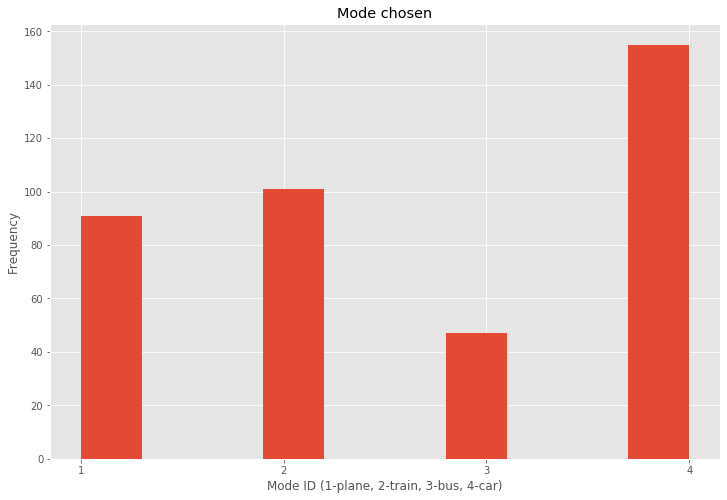

In [26]:
print("Dataset size:", len(df))
df['mode_chosen'].hist();
plt.title('Mode chosen')
plt.xlabel('Mode ID (1-plane, 2-train, 3-bus, 4-car)')
plt.ylabel('Frequency')
plt.xticks([1,2,3,4]);

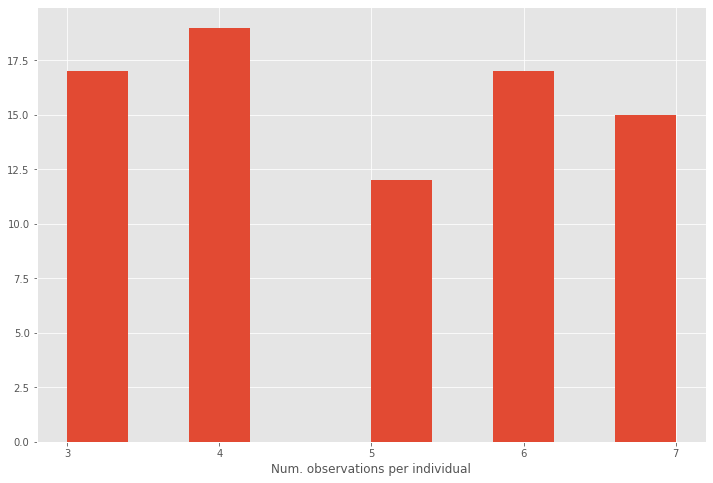

In [27]:
plt.hist(df.groupby("individual").count()["mode_chosen"])
plt.xticks(np.unique(df.groupby("individual").count()))
plt.xlabel('Num. observations per individual');

In [28]:
# more statistics
df.describe()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,196.500000,39.032995,34.228426,1.761421,61.215736,83.350254,132.005076,100.510152,35.685279,49.832487,597.847716,127.101523,42.000000,33.073604,624.718274,114.065990,21.101523,565.667513,94.170051,2.675127
std,113.882249,22.816704,19.276048,1.030790,15.780674,26.625461,45.484891,29.081987,12.712417,26.727488,245.826336,55.855820,11.962409,12.787644,233.524090,43.468285,15.164236,263.027420,44.398771,1.213176
min,0.000000,1.000000,2.000000,1.000000,5.000000,44.000000,63.000000,56.000000,1.000000,11.000000,255.000000,42.000000,5.000000,12.000000,227.000000,45.000000,2.000000,180.000000,32.000000,1.000000
25%,98.250000,19.250000,18.000000,1.000000,64.000000,59.250000,95.750000,72.000000,34.000000,30.000000,357.000000,74.000000,35.000000,25.000000,406.000000,73.000000,10.000000,315.000000,52.000000,2.000000
50%,196.500000,39.000000,35.000000,1.000000,64.000000,81.000000,125.000000,96.000000,34.000000,36.000000,602.000000,119.000000,35.000000,31.000000,599.000000,105.000000,16.000000,577.000000,96.000000,3.000000
75%,294.750000,57.750000,45.000000,2.000000,69.000000,105.000000,158.000000,125.000000,44.000000,72.000000,873.000000,177.000000,53.000000,44.000000,870.000000,145.000000,31.500000,858.000000,135.000000,4.000000
max,393.000000,80.000000,72.000000,6.000000,90.000000,180.000000,333.000000,197.000000,99.000000,111.000000,1104.000000,269.000000,60.000000,70.000000,1110.000000,222.000000,86.000000,1440.000000,228.000000,4.000000


Lets now preprocess the data by:
- Separating the inputs (x) from the targets (y)
- Standardizing the input variables in order to have zero mean and unit standard deviation

In [29]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,2:-1]
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)

(394, 17)
(394,)
(394,)


In [30]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [31]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 260
num test: 134


Just for the sake of comparision (and for fun!), lets run logistic regression from the popular sklearn package.

In [32]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 4 1 4 4 4 3 1 4 2 1 4 2 1 4 4 4 4 4 2 4 1 4 1 2 4 4 4 2 3 4 4
 3 2 4 4 4 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 3 2 4 2 4
 4 4 1 4 2 2 4 4 1 4 3 4 4 2 1 4 3 1 4 2 1 4 1 4 4 4 1 1 2 1 3 2 4 4 4 4 4
 4 4 1 3 3 1 4 3 2 4 1 4 2 1 3 2 2 2 4 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6194029850746269


Ok, time to do it in Pyro!

Since we don't have a column in the inputs (X) that is always equal to 1, we need to incorporate the bias term in our model explicitly. Hence, we shall include an extra set of bias parameters $\boldsymbol\alpha = \{\alpha_1,\dots,\alpha_C\}$ in the model. The likelihood is then of the form:

\begin{align}
y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\boldsymbol\alpha + \textbf{B} \textbf{x}_n^T))
\end{align}

where $\textbf{B} = (\boldsymbol\beta_1,\dots,\boldsymbol\beta_C)^T$

Remember that Pyro expects the targets $y_n$ as integers in {0,1,2,3}!

Your turn now :-) Can you implement it in Pyro?

In [33]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)))  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat))) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

Let's prepare the data for Pyro by converting it into PyTorch tensors:

In [34]:
n_cat = 4
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

Run approximate Bayesian inference using SVI:

In [35]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train-1)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1226.1
[1000] ELBO: 684.6
[2000] ELBO: 415.6
[3000] ELBO: 375.0
[4000] ELBO: 353.6
[5000] ELBO: 349.7
[6000] ELBO: 340.6
[7000] ELBO: 334.5
[8000] ELBO: 334.4
[9000] ELBO: 337.7
[10000] ELBO: 334.1
[11000] ELBO: 334.7
[12000] ELBO: 324.6
[13000] ELBO: 323.9
[14000] ELBO: 326.3
[15000] ELBO: 324.2
[16000] ELBO: 345.8
[17000] ELBO: 320.3
[18000] ELBO: 323.3
[19000] ELBO: 319.5
[20000] ELBO: 315.9
[21000] ELBO: 316.5
[22000] ELBO: 307.4
[23000] ELBO: 321.5
[24000] ELBO: 306.8
[25000] ELBO: 326.9
[26000] ELBO: 313.3
[27000] ELBO: 311.0
[28000] ELBO: 321.9
[29000] ELBO: 316.3
[30000] ELBO: 316.2
[31000] ELBO: 313.4
[32000] ELBO: 315.2
[33000] ELBO: 314.4
[34000] ELBO: 307.7
[35000] ELBO: 306.2
[36000] ELBO: 314.4
[37000] ELBO: 347.8
[38000] ELBO: 329.9
[39000] ELBO: 314.8


Upon convergence, we can use the ```Predictive``` class to extract samples from posterior:

In [36]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

Plot posterior distributions for the parameters using the ```seaborn``` package:

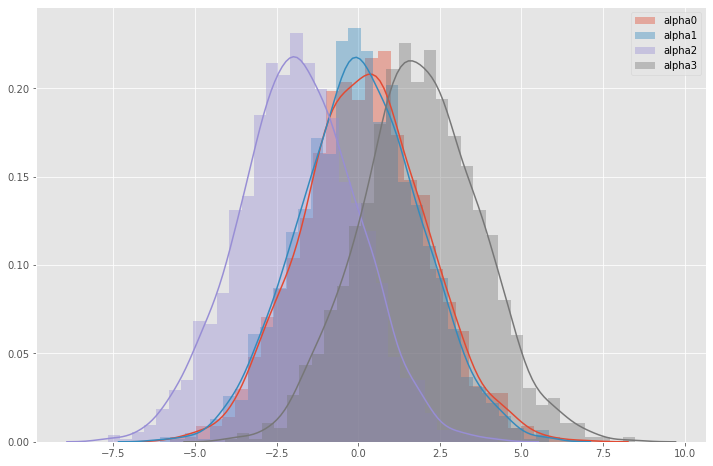

In [37]:
for c in range(n_cat):
    sns.distplot(samples["alpha"][:,0,c].detach().numpy())
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

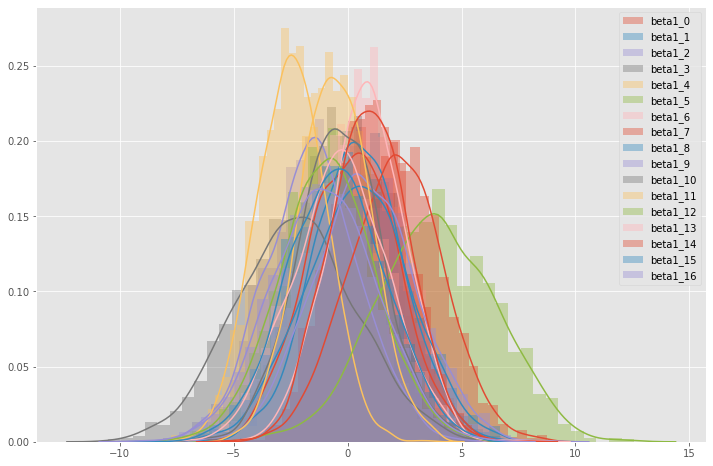

In [38]:
for d in range(X.shape[1]):
    sns.distplot(samples["beta"][:,d,0].detach().numpy())
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

We can now use the inferred posteriors to make predictions for the testset and compute the corresponding accuracy:

In [39]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [40]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 1 4 4 4 3 1 4 2 1 4 2 1 2 4 4 4 4 2 4 1 4 1 2 4 4 4 2 3 4 4
 3 2 1 4 4 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 4 4 4 1 4 3 1 4 2 1 4 1 1 4 4 1 1 4 4 3 2 4 4 4 4 4
 4 4 1 3 1 1 4 3 2 4 1 4 2 1 1 2 2 2 4 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.664179104477612


You should have obtained a similar accuracy to sklearn, or even better...

Moreover, you now have full posterior distributions for the model parameters. Therefore, you can see how each trip characteristic affects the travel mode choices, but also how uncertain the model is about that relationship. For example, a very wide posterior distribution of a coefficient $\beta$ around 3, would tell you that, on average, the corresponding variables contributes positively to a having preference for a given mode, but the model is not very confident about that conclusion.

### Inference with MCMC

Lastly, for the sake of completeness, we show below how to approximate Bayesian inference in the model using MCMC. However, we note that the code below takes a while (approx. 10 minutes) to run.

In [19]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, n_cat, y_train-1) # Pyro accepts categories starting from 0

Sample: 100%|██████████| 600/600 [11:37,  1.16s/it, step size=9.92e-03, acc. prob=0.964]


In [20]:
samples = mcmc.get_samples()
alpha_hat = samples["alpha"].mean(axis=0).numpy()
beta_hat = samples["beta"].mean(axis=0).numpy()

In [21]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 1 4 4 4 3 1 4 2 1 4 2 1 2 4 4 4 4 2 4 1 4 1 2 4 4 4 4 3 4 4
 3 2 1 4 4 2 2 2 4 1 3 2 3 1 4 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 4 4 4 1 4 3 1 4 2 1 4 1 1 4 4 1 1 4 4 3 2 4 4 4 4 4
 4 4 1 3 1 1 4 3 2 4 1 4 2 1 1 2 2 2 4 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.664179104477612
